In [55]:
import pandas as pd
import numpy as np
import sqlite3

from sklearn.metrics.pairwise import euclidean_distances
from sklearn.decomposition import PCA
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import KMeans

import matplotlib as mpl
import matplotlib.pyplot as plt


In [56]:
def plot_figure(fig_width=2, fig_height=2):
    #define apeearance of figures

    COLOR = 'black'


    # Edit the font, font size, color and axes width

    plt.rcParams['font.size'] = 15
    plt.rcParams['axes.linewidth'] = 0.5

    tick_size=3
    mpl.rcParams['font.family'] = 'Arial'
    mpl.rcParams['text.color'] = COLOR
    mpl.rcParams['axes.labelcolor'] = COLOR
    mpl.rcParams['axes.edgecolor'] = COLOR
    mpl.rcParams['xtick.color'] = COLOR
    mpl.rcParams['ytick.color'] = COLOR


    # Create figure object and store it in a variable called 'fig'
    fig = plt.figure(figsize=(fig_width, fig_height))

    # Add axes object to the figure that takes up entire figure
    ax = fig.add_axes([0, 0, 1, 1])


    # Edit the major and minor ticks of the x and y axes
    ax.xaxis.set_tick_params(which='major', size=tick_size, width=plt.rcParams['axes.linewidth'], direction='in', top='on')
    ax.xaxis.set_tick_params(which='minor', size=tick_size, width=plt.rcParams['axes.linewidth'], direction='in', top='on')
    ax.yaxis.set_tick_params(which='major', size=tick_size, width=plt.rcParams['axes.linewidth'], direction='in', right='on')
    ax.yaxis.set_tick_params(which='minor', size=tick_size, width=plt.rcParams['axes.linewidth'], direction='in', right='on')

    return fig, ax

In [57]:
nlp_file_path = f"CroLyrics_data/nlp_all.csv"
df = pd.read_csv(nlp_file_path)
df_main_words = df[df.upos.isin(["ADV", "ADJ", "NOUN", "VERB", "PROPN", "DET"])].copy() #keep only these word types
df_main_words.dropna(subset=["lemma"], inplace=True)
df_main_words.reset_index(drop=True, inplace=True)
df_main_words["Artist_ID"] = df_main_words.Song_ID.str.split("_").map(lambda x: x[0])


In [58]:
def get_artist_name(artist_code):
    conn = sqlite3.connect('CroLyrics_data/info.db')
    c = conn.cursor()
    c.execute("SELECT name FROM artists WHERE code=:code", {'code': artist_code})
    return c.fetchone()

In [59]:
df_unique_lemmas_artist = df_main_words.drop_duplicates(subset=["lemma", "Artist_ID"])
df_unique_lemmas_song = df_main_words.drop_duplicates(subset=["lemma", "Song_ID"])

In [60]:
#make tf_idf dataframe 

lemma_frequencies_unique_artist =df_unique_lemmas_artist.lemma.value_counts()
lemma_frequencies_unique_artist = lemma_frequencies_unique_artist[lemma_frequencies_unique_artist>5]#word has to appear in at least x artists

lemma_frequencies_unique_songs = df_unique_lemmas_song.lemma.value_counts()
lemma_frequencies_unique_songs = lemma_frequencies_unique_songs[lemma_frequencies_unique_songs>10]  #word has to appear in at least x songs

lemma_frequencies_unique_songs = lemma_frequencies_unique_songs[lemma_frequencies_unique_songs.index.isin(lemma_frequencies_unique_artist.index)]#word has to appear in at least x artists

num_songs = len(df.Song_ID.unique())
artist_ids = df_main_words.Artist_ID.unique()
df_tf_idf = pd.DataFrame()
for artist in artist_ids:
    lemma_freq_artist = df_unique_lemmas_song[df_unique_lemmas_song.Artist_ID==artist].lemma.value_counts()
    lemma_freq_artist = lemma_freq_artist[(lemma_freq_artist.index.isin(lemma_frequencies_unique_songs.index))]
    lemma_freq_artist = lemma_freq_artist/lemma_freq_artist.sum()
    tf = np.log(1+lemma_freq_artist)
    idf = np.log(num_songs / lemma_frequencies_unique_songs[lemma_freq_artist.index])
    df_tf_idf.loc[artist, lemma_freq_artist.index] = (tf*idf)

In [61]:
df_tf_idf = df_tf_idf.replace(0,np.nan).dropna(axis=1,how="all") #drop columns where all values are 0
df_tf_idf = df_tf_idf.fillna(0)
df_tf_idf.index = [get_artist_name(i)[0] for i in df_tf_idf.index]


In [62]:
df_tf_idf.head(10)

,sav,moj,taj,samo,ljubav,znati,tvoj,srce,život,mnogo,...,lep,dnevnik,zauvjek,skupo,pokazivati,složiti,zuriti,princeza,ekran,bevanda
Mišo Kovač,0.008487,0.010018,0.010107,0.012166,0.013120,0.010305,0.011304,0.012147,0.014502,0.014234,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Prljavo Kazalište,0.009768,0.008552,0.011625,0.009482,0.008246,0.011787,0.007762,0.006938,0.003134,0.006284,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Crvena Jabuka,0.007156,0.008851,0.009469,0.010491,0.008724,0.009978,0.011238,0.007941,0.006809,0.010241,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Gibonni,0.007286,0.009842,0.012713,0.007130,0.010019,0.012783,0.011836,0.007474,0.003683,0.008765,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Zlatko Pejaković,0.010033,0.010779,0.011364,0.010515,0.009519,0.009649,0.008994,0.012999,0.015579,0.008596,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Leteći Odred,0.008680,0.007999,0.010936,0.014331,0.014724,0.009432,0.005382,0.012730,0.010149,0.013229,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Severina,0.008157,0.010073,0.009943,0.011061,0.011752,0.009680,0.011339,0.011220,0.006871,0.008861,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Doris Dragović,0.009813,0.012757,0.009105,0.012820,0.013187,0.009778,0.013454,0.015346,0.010191,0.008898,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Thompson,0.006537,0.009696,0.009557,0.008810,0.009214,0.007826,0.007080,0.009071,0.012265,0.005572,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Danijela Martinović,0.008778,0.010481,0.010939,0.011484,0.013154,0.009596,0.011971,0.016097,0.014899,0.007496,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [63]:

explained_variance = []
for i in range(df_tf_idf.shape[0]):
    pca = PCA(n_components=i+1, random_state=42)
    pca.fit(df_tf_idf)
    explained_variance.append(np.sum(pca.explained_variance_ratio_))


Text(0, 0.5, 'Variance retained')

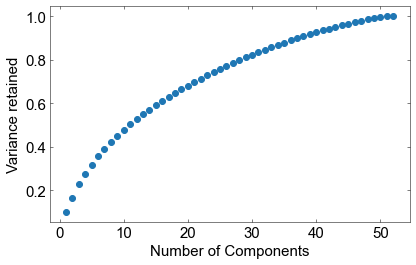

In [64]:
fig, ax = plot_figure(5, 3)
ax.scatter(np.arange(1, 53), explained_variance)
ax.set_xlabel("Number of Components")
ax.set_ylabel("Variance retained")

In [65]:
pca = PCA(n_components=12, random_state=42)
tf_idf_pca = pca.fit_transform(df_tf_idf)

print(np.sum(pca.explained_variance_ratio_))


0.5269886674640687


In [66]:

clustering = AffinityPropagation(random_state=42).fit(tf_idf_pca)


clustering.labels_

tf_idf_pca = tf_idf_pca.copy(order='C')

clusters = clustering.predict(tf_idf_pca)
cluster_centers_indices = clustering.cluster_centers_indices_


In [67]:
df_tf_idf_clusters = df_tf_idf.copy()
df_tf_idf_clusters["clusters"] = clusters


In [68]:
cluster_counts = df_tf_idf_clusters["clusters"].value_counts()
cluster_counts
for c in cluster_counts.index:
    print("/////////")
    print(c)
    for a in df_tf_idf_clusters[df_tf_idf_clusters.clusters == c].reset_index()["index"]:
        print(a)

/////////
11
Crvena Jabuka
Zlatko Pejaković
Leteći Odred
Severina
Danijela Martinović
Novi Fosili
Parni Valjak
Plavi Orkestar
Vlado Kalember
Jasna Zlokić
Jole
Željko Bebek
Luka Nižetić
Jasmin Stavros
Magazin
Ivan Zak
Gazde
/////////
1
Gibonni
Colonia
Jacques Houdek
Josipa Lisac
Tony Cetinski
Nina Badrić
Vanna
Boris Novković
Divlje Jagode
/////////
0
Mišo Kovač
Doris Dragović
Petar Grašo
Oliver Dragojević
Tereza Kesovija
Goran Karan
/////////
5
Thompson
Miroslav Škoro
Slavonske Lole
Najbolji Hrvatski Tamburaši
Mate Bulić
Krunoslav Kićo Slabinac
/////////
2
Prljavo Kazalište
Zabranjeno Pušenje
Bijelo Dugme
Darko Rundek
Hladno Pivo
/////////
9
Mladen Grdović
Vinko Coce
/////////
3
Maja Šuput
/////////
4
Aerodrom
/////////
6
Baruni
/////////
7
Haustor
/////////
8
Psihomodo Pop
/////////
10
Maja Šuput & EnJoy
/////////
12
Dalmatino


In [69]:
cluster_names_dict = {}
for i in range(len(cluster_counts)):
    cluster_names_dict[i] = np.nan
cluster_names_dict[11] = "Svadba"
cluster_names_dict[1] = "Urbano"
cluster_names_dict[0] = "Dalmacija"
cluster_names_dict[5] = "Domovina"
cluster_names_dict[2] = "Cro-rock"


In [70]:
df_tf_idf_clusters["cluster_name"] = df_tf_idf_clusters.clusters.apply(lambda x: cluster_names_dict[x])

In [71]:
##take the clusters that have only one (or few) members and calculate distance to the representatives of other clusters, and find the one which is closest

for index, value in zip(cluster_counts.index, cluster_counts.values):
    if value < 3:
        artist_name = df_tf_idf_clusters[df_tf_idf_clusters.clusters == index].reset_index()["index"]
        for artist_name in artist_name:
            print(artist_name)
            coordinates = tf_idf_pca[cluster_centers_indices[index]]
            other_clusters_dist=[]        
            for k in cluster_centers_indices:
                other_clusters_dist.append(np.round(euclidean_distances(coordinates.reshape(1, -1), tf_idf_pca[k].reshape(1, -1))[0][0], 5))

            masked_a = np.ma.masked_equal(other_clusters_dist, 0.0, copy=False)
            c = cluster_centers_indices[other_clusters_dist.index(masked_a.min())]
            print(df_tf_idf_clusters.iloc[c].cluster_name)
            print("////")
            
            ##reassign to new cluster
            df_tf_idf_clusters.loc[artist_name, "clusters"] = df_tf_idf_clusters.iloc[c].clusters
            df_tf_idf_clusters.loc[artist_name, "cluster_name"] = df_tf_idf_clusters.iloc[c].cluster_name


Mladen Grdović
Dalmacija
////
Vinko Coce
Dalmacija
////
Maja Šuput
Svadba
////
Aerodrom
Cro-rock
////
Baruni
Svadba
////
Haustor
Cro-rock
////
Psihomodo Pop
Cro-rock
////
Maja Šuput & EnJoy
Svadba
////
Dalmatino
Dalmacija
////


In [72]:
cluster_counts = df_tf_idf_clusters["clusters"].value_counts()
cluster_counts
for c in cluster_counts.index:
    print("/////////")
    print(cluster_names_dict[c])
    print("/////////")
    for a in df_tf_idf_clusters[df_tf_idf_clusters.clusters == c].reset_index()["index"]:
        print(a)
    print("/////////")


/////////
Svadba
/////////
Crvena Jabuka
Zlatko Pejaković
Leteći Odred
Severina
Danijela Martinović
Novi Fosili
Parni Valjak
Plavi Orkestar
Maja Šuput
Baruni
Vlado Kalember
Jasna Zlokić
Jole
Željko Bebek
Luka Nižetić
Jasmin Stavros
Maja Šuput & EnJoy
Magazin
Ivan Zak
Gazde
/////////
/////////
Dalmacija
/////////
Mišo Kovač
Doris Dragović
Petar Grašo
Oliver Dragojević
Tereza Kesovija
Mladen Grdović
Vinko Coce
Goran Karan
Dalmatino
/////////
/////////
Urbano
/////////
Gibonni
Colonia
Jacques Houdek
Josipa Lisac
Tony Cetinski
Nina Badrić
Vanna
Boris Novković
Divlje Jagode
/////////
/////////
Cro-rock
/////////
Prljavo Kazalište
Zabranjeno Pušenje
Aerodrom
Haustor
Bijelo Dugme
Psihomodo Pop
Darko Rundek
Hladno Pivo
/////////
/////////
Domovina
/////////
Thompson
Miroslav Škoro
Slavonske Lole
Najbolji Hrvatski Tamburaši
Mate Bulić
Krunoslav Kićo Slabinac
/////////
